In [1]:
import multiprocessing
multiprocessing.set_start_method("fork")

In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [4]:
import gwtones

In [5]:
from importlib import reload

# Data

## PSDs and ACFs

In [6]:
# simulate 2s of white Gaussian noise sampled at 8192 Hz

x = gwtones.Data(random.normal(0, 1, 16384),
                 ifo='H1', index=arange(16384)/8192)
x

0.000000   -1.702855
0.000122   -1.418076
0.000244   -1.322151
0.000366   -1.288389
0.000488    1.890059
              ...   
1.999390   -1.703449
1.999512    0.638285
1.999634   -1.121721
1.999756    0.310789
1.999878   -0.847329
Length: 16384, dtype: float64

In [7]:
# access some attributes
x.ifo, x.delta_t, x.duration, x.delta_f, x.fsamp

('H1', 0.0001220703125, 2.0, 0.5, 8192.0)

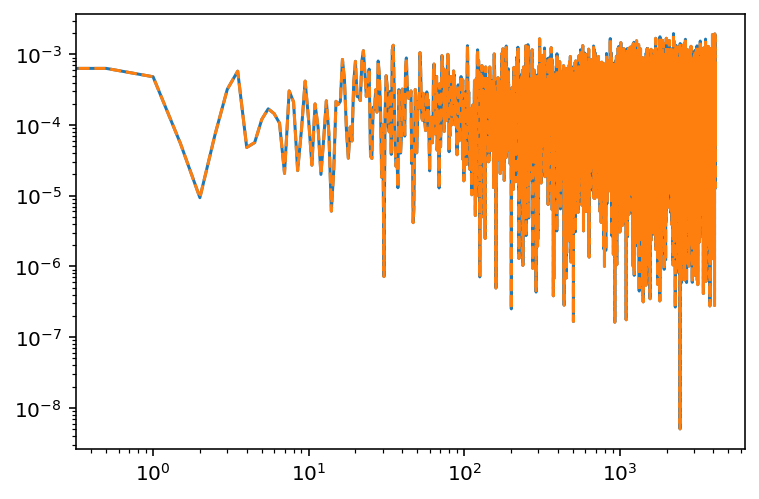

In [8]:
# get a PSD
p = x.get_psd(nperseg=len(x))

# this is the same as the Welch PSD
import scipy.signal as sig
freq, psd = sig.welch(x, fs=x.fsamp, nperseg=len(x))

loglog(p.freq, p)
loglog(freq, psd, ls='--')

In [9]:
# the PSD is a FrequencySeries with some attributes
p.delta_t, p.duration, p.delta_f, p.fsamp

(0.0001220703125, 1.0001220703125, 0.5, 8192.0)

In [10]:
# from the psd we can get an ACF
acf_fd = p.to_acf()
acf_fd

0.000000    1.019641
0.000122    0.008287
0.000244   -0.005363
0.000366   -0.000379
0.000488    0.006131
              ...   
1.999390   -0.013797
1.999512    0.006131
1.999634   -0.000379
1.999756   -0.005363
1.999878    0.008287
Length: 16384, dtype: float64

In [11]:
# or we could have produced this directly from the original data
x.get_acf(method='fd')

/Users/maxisi/miniconda3/envs/gwtones/lib/python3.9/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 49152 is greater than input length  = 16384, using nperseg = 16384
  warnings.warn('nperseg = {0:d} is greater than input length '


0.000000    1.019641
0.000122    0.008287
0.000244   -0.005363
0.000366   -0.000379
0.000488    0.006131
              ...   
1.999390   -0.013797
1.999512    0.006131
1.999634   -0.000379
1.999756   -0.005363
1.999878    0.008287
Length: 16384, dtype: float64

In [12]:
# the default method is through correlate
# (see documentation or code for all options)
acf_td = x.get_acf()
acf_td

0.000000    1.009128
0.000122   -0.000683
0.000244   -0.001250
0.000366    0.001224
0.000488    0.007650
              ...   
1.999390    0.000090
1.999512    0.000072
1.999634    0.000158
1.999756    0.000041
1.999878    0.000088
Length: 16384, dtype: float64

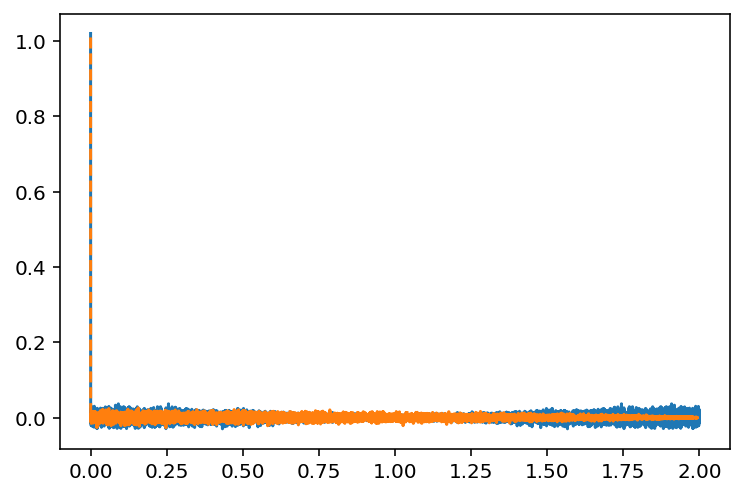

In [13]:
plot(acf_fd.time, acf_fd)
plot(acf_td.time, acf_td, ls='--')

In [14]:
%time

# acfs objects know how to compute, and cache, the cholesky decomp 
# of their corresponding covariance matrix

acf_td.cholesky

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


array([[ 1.00455372e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.79632554e-04,  1.00455349e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.24420698e-03, -6.80474480e-04,  1.00455272e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.57346361e-04,  7.20783971e-05,  8.99692147e-05, ...,
         7.92252946e-01,  0.00000000e+00,  0.00000000e+00],
       [ 4.08508650e-05,  1.57374035e-04,  7.21291996e-05, ...,
         1.95786607e-03,  7.92252691e-01,  0.00000000e+00],
       [ 8.76671160e-05,  4.09101857e-05,  1.57482811e-04, ...,
        -7.87341737e-03,  1.96159457e-03,  7.92239087e-01]])

In [15]:
%time
L = acf_td.cholesky

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs


## Conditioning

In [16]:
# Data objects know how to return a conditioned copy of themselves

# highpass and downsample by 2, assume analysis time will be 1
x_cond = x.condition(flow=20, ds=2, t0=1)

# NOTE: condition takes a t0 argument specify a target time to be
# preserved after decimation by rolling

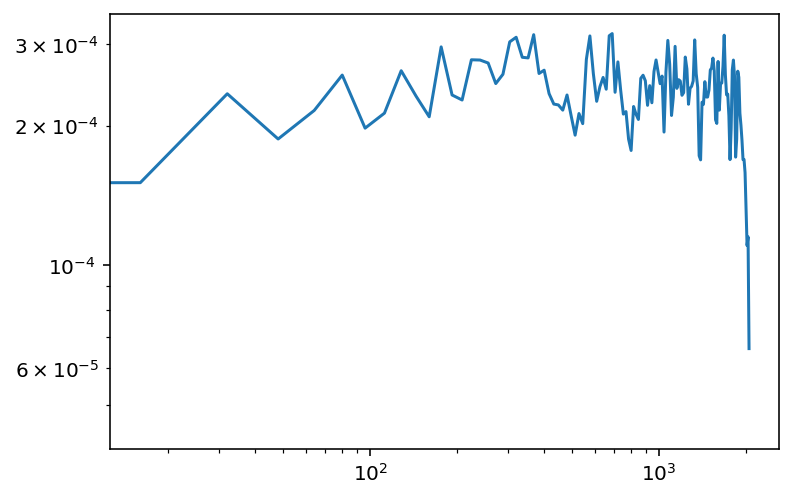

In [17]:
# look at the new psd (highpass won't be visible bc example seglen was too short)
p_cond = x_cond.get_psd()
loglog(p_cond.freq, p_cond)

In [18]:
# the conditioned data remember their identity
x_cond.ifo, x.ifo

('H1', 'H1')

# Fitting

## Frequency and damping

In [19]:
from importlib import reload
reload(gwtones.fit)

<module 'gwtones.fit' from '/Users/maxisi/src/gwtones/gwtones/fit.py'>

### setting prior and adding data

In [20]:
# let's create a fit object for a simple f-tau fit

# creating a Fit() object requires only the `model` key,
# others can be added later
# besides the `modes` kwarg, other arguments will be 
# passed to stan_data
f = gwtones.fit.Fit(model='ftau', modes=2, A_max=0.5)

In [21]:
# we've created a model with 2 arbitrary modes
f.n_modes

2

In [22]:
# we've already specified we want the prior to allow ampltitudes
# up to A_max=0.5, we can check what other parameters we can set
f.valid_model_options

['A_max', 'f_max', 'f_min', 'gamma_max', 'gamma_min']

In [23]:
# let's set the additional prior bounds we left out above
f.update_prior(f_min=100, f_max=500, gamma_min=100, gamma_max=500)

In [24]:
f.prior_settings

{'A_max': 0.5, 'f_max': 500, 'f_min': 100, 'gamma_max': 500, 'gamma_min': 100}

In [25]:
# let's add data to our Fit
f.add_data(x_cond, acf=acf_td)

In [26]:
f.data

{'H1': 0.000000    0.331846
 0.000244    0.463929
 0.000488    2.600193
 0.000732    1.570961
 0.000977    1.654964
               ...   
 1.998779   -0.187751
 1.999023    1.361641
 1.999268   -0.099803
 1.999512   -0.297367
 1.999756   -0.010957
 Length: 8192, dtype: float64}

In [27]:
f.acfs

{'H1': 0.000000    1.009128
 0.000122   -0.000683
 0.000244   -0.001250
 0.000366    0.001224
 0.000488    0.007650
               ...   
 1.999390    0.000090
 1.999512    0.000072
 1.999634    0.000158
 1.999756    0.000041
 1.999878    0.000088
 Length: 16384, dtype: float64}

In [28]:
# if we hadn't provided an ACF to add data, we could have asked
# Fit to compute it automatically for all added IFOs
f.compute_acfs()

# calling compute_acfs rewrote the ACF we had added

# NOTE: compute_acfs takes `shared` boolean argument that specifices if all
# IFOs are to share a single ACF, in which case the ACF is only computed
# once from the data of the first IFO (useful for simulated data)

# it also accepts an `ifos` argument, giving specific IFOs for which to 
# compute ACF, otherwise computes it for all

In [29]:
# now let's set an analysis target
# for this model this is just a start time (no sky loc required)
# and optionally an analysis duration

# let's pick t0 in the middle of the segment
t0 = x.time[0] + 0.5*x.duration

# and pass a duration (in same unit as time array)
# --- also accept a number of samples instead.
f.set_target(t0, duration=0.02)

In [30]:
f.target

Target(t0=1.0, ra=None, dec=None, psi=None)

In [31]:
f.t0, f.duration, f.n_analyze

(1.0, 0.02, 82)

In [32]:
# the data are not truncated at this point
# the following function returns the right slice 
f.analysis_data

{'H1': 1.000000   -0.478834
 1.000244   -0.265777
 1.000488    1.028610
 1.000732   -0.512883
 1.000977   -0.331096
               ...   
 1.018799    0.449031
 1.019043    0.138719
 1.019287   -0.614626
 1.019531   -0.666156
 1.019775   -0.266814
 Length: 82, dtype: float64}

In [33]:
# we can get the index of the first analysis sample in the big segment
# corresponding to the analysis time (closest to t0)
f.start_indices

{'H1': 4096}

In [34]:
f.start_times

{'H1': 1.0}

In [35]:
f.data['H1'].time[f.start_indices['H1']]

1.0

### Compiling and fitting

In [36]:
# so far the Stan model hasn't compiled
# this will happen automatically the first time we run
# otherwise, we can force this to happen by calling compile()

f.compile()

In [37]:
# note this won't be recompile unless we use the force argument
f.compile()

In [38]:
gwtones.MODELS

('ftau', 'mchi')

In [39]:
gwtones.fit.MODELS

('ftau', 'mchi')

In [40]:
# to run the model all we need to do is call run()
# kwargs will be interpreted as stan run time settings (number of chains etc)
# the model won't be compiled again since we already compiled it above
# (and this would be true for other instance of Fit with the ftau model in 
# the same session)
f.run()

Running ftau


In [41]:
# the result has been saved within the Fit object itself
f.result

Inference data with groups:
	> posterior
	> sample_stats

In [42]:
# we could've also done a prior-only run
f.run(prior=True)

Running ftau


In [43]:
# the result is saved in prior
f.prior

Inference data with groups:
	> posterior
	> sample_stats

## Mass and spin

In [44]:
from importlib import reload
reload(gwtones.fit)

<module 'gwtones.fit' from '/Users/maxisi/src/gwtones/gwtones/fit.py'>

### setting prior and adding data

In [45]:
# the mass and spin fit works much in the same way

f2 = gwtones.fit.Fit(model='mchi', A_max=0.5)

In [46]:
# this time, we didn't add modes above, instead let's set 
# the modes to be a sequence of overtones (by default 22 mode, prograde)

# requesting 2 modes implies an N=1 fit (fundamental + overtone)
f2.set_tone_sequence(2)

In [47]:
# we can check that the modes have been added correctly
f2.modes

[ModeIndex(p=1, s=-2, l=2, m=2, n=0), ModeIndex(p=1, s=-2, l=2, m=2, n=1)]

In [48]:
# NOTE: the p index is +1 for prograde, and -1 for retrograde modes
# we could have equivalently passed `modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)]`
# when creating the Fit instance, or used its set_modes method with the same argument

In [49]:
# we've already specified we want the prior to allow amplitudes
# up to A_max=0.5, we can check what other parameters we can set
f2.valid_model_options

['A_max',
 'perturb_f',
 'perturb_tau',
 'df_max',
 'dtau_max',
 'M_min',
 'M_max',
 'chi_min',
 'chi_max']

In [50]:
# let's set some additional prior bounds, for the others we'll use the default
f2.update_prior(M_min=50, M_max=100)

f2.prior_settings

{'A_max': 0.5,
 'perturb_f': array([0., 0.]),
 'perturb_tau': array([0., 0.]),
 'df_max': 0.9,
 'dtau_max': 0.9,
 'M_min': 50,
 'M_max': 100,
 'chi_min': 0,
 'chi_max': 0.99}

In [51]:
# let's add data to our Fit
f2.add_data(x_cond)

# let's add a second IFO (cheating by just duplicating the same data)
y_cond = x_cond.copy()
y_cond.ifo = 'L1'

f2.add_data(y_cond)

In [52]:
f2.data

{'H1': 0.000000    0.331846
 0.000244    0.463929
 0.000488    2.600193
 0.000732    1.570961
 0.000977    1.654964
               ...   
 1.998779   -0.187751
 1.999023    1.361641
 1.999268   -0.099803
 1.999512   -0.297367
 1.999756   -0.010957
 Length: 8192, dtype: float64,
 'L1': 0.000000    0.331846
 0.000244    0.463929
 0.000488    2.600193
 0.000732    1.570961
 0.000977    1.654964
               ...   
 1.998779   -0.187751
 1.999023    1.361641
 1.999268   -0.099803
 1.999512   -0.297367
 1.999756   -0.010957
 Length: 8192, dtype: float64}

In [53]:
f2.ifos

['H1', 'L1']

In [54]:
# we haven't added any ACFs
f2.acfs

{}

In [55]:
# let's compute ACFs for all IFOs, but let's tell Fit
# that they all share a single ACF
f2.compute_acfs(shared=True)

f2.acfs

{'H1': 0.000000    4.875487e-01
 0.000244    1.781288e-02
 0.000488   -1.359329e-02
 0.000732    1.614836e-02
 0.000977   -1.015378e-02
                 ...     
 1.998779   -2.141040e-05
 1.999023   -4.698151e-05
 1.999268   -2.436121e-05
 1.999512   -1.266642e-05
 1.999756   -4.438537e-07
 Length: 8192, dtype: float64,
 'L1': 0.000000    4.875487e-01
 0.000244    1.781288e-02
 0.000488   -1.359329e-02
 0.000732    1.614836e-02
 0.000977   -1.015378e-02
                 ...     
 1.998779   -2.141040e-05
 1.999023   -4.698151e-05
 1.999268   -2.436121e-05
 1.999512   -1.266642e-05
 1.999756   -4.438537e-07
 Length: 8192, dtype: float64}

In [56]:
# now let's set an analysis target this time with a sky location

# let's pick t0 in the middle of the segment
# now the truncation time will be defined to be at geocenter
t0 = x.time[0] + 0.5*x.duration

# and pass a duration (in same unit as time array)
# --- also accept a number of samples instead.
f2.set_target(t0, 1.92, 0.8, 0, duration=0.02)

In [57]:
f2.target

Target(t0=1.0, ra=1.92, dec=0.8, psi=0)

In [58]:
f2.has_target

True

In [59]:
f2.t0, f.duration, f.n_analyze

(1.0, 0.02, 82)

In [60]:
# the target allows the fit to compute antenna patterns
f2.antenna_patterns

{'H1': [0.27314198380407506, -0.36414750450706745],
 'L1': [0.023415325210703053, 0.41321163714139464]}

In [61]:
# the data are not truncated at this point
# the following function returns the right slice 
# NOTE: the sky location is automatically taken into account
# so note the tart times are different
f2.analysis_data

{'H1': 0.994873   -0.054632
 0.995117   -0.553743
 0.995361    2.011032
 0.995605    0.221234
 0.995850   -0.735433
               ...   
 1.013672   -0.191998
 1.013916    0.888552
 1.014160   -0.349833
 1.014404   -1.277386
 1.014648    0.689430
 Length: 82, dtype: float64,
 'L1': 0.993652    0.857596
 0.993896   -0.049674
 0.994141    0.815936
 0.994385    0.568779
 0.994629    0.350503
               ...   
 1.012451    0.378266
 1.012695   -0.413795
 1.012939   -0.950680
 1.013184   -0.741632
 1.013428    0.886384
 Length: 82, dtype: float64}

In [62]:
# we can get the index of the first analysis sample in the big segment
# corresponding to the analysis time (closest to t0)
f2.start_indices

{'H1': 4075, 'L1': 4070}

In [63]:
f2.start_times

{'H1': 0.9948112141035089, 'L1': 0.9936281071692268}

In [64]:
f2.data['H1'].time[f2.start_indices['H1']]

0.994873046875

### Compiling and fitting

In [65]:
# the rest is the same as above
# the kerr model internally takes care of f,tau fit coefficients

In [66]:
# to run the model all we need to do is call run()
# kwargs will be interpreted as stan run time settings (number of chains etc)
# the model will be compiled now since we didn't manually compile it before
f2.run()

Running mchi


In [67]:
# the result has been saved within the Fit object itself
f2.result

Inference data with groups:
	> posterior
	> sample_stats

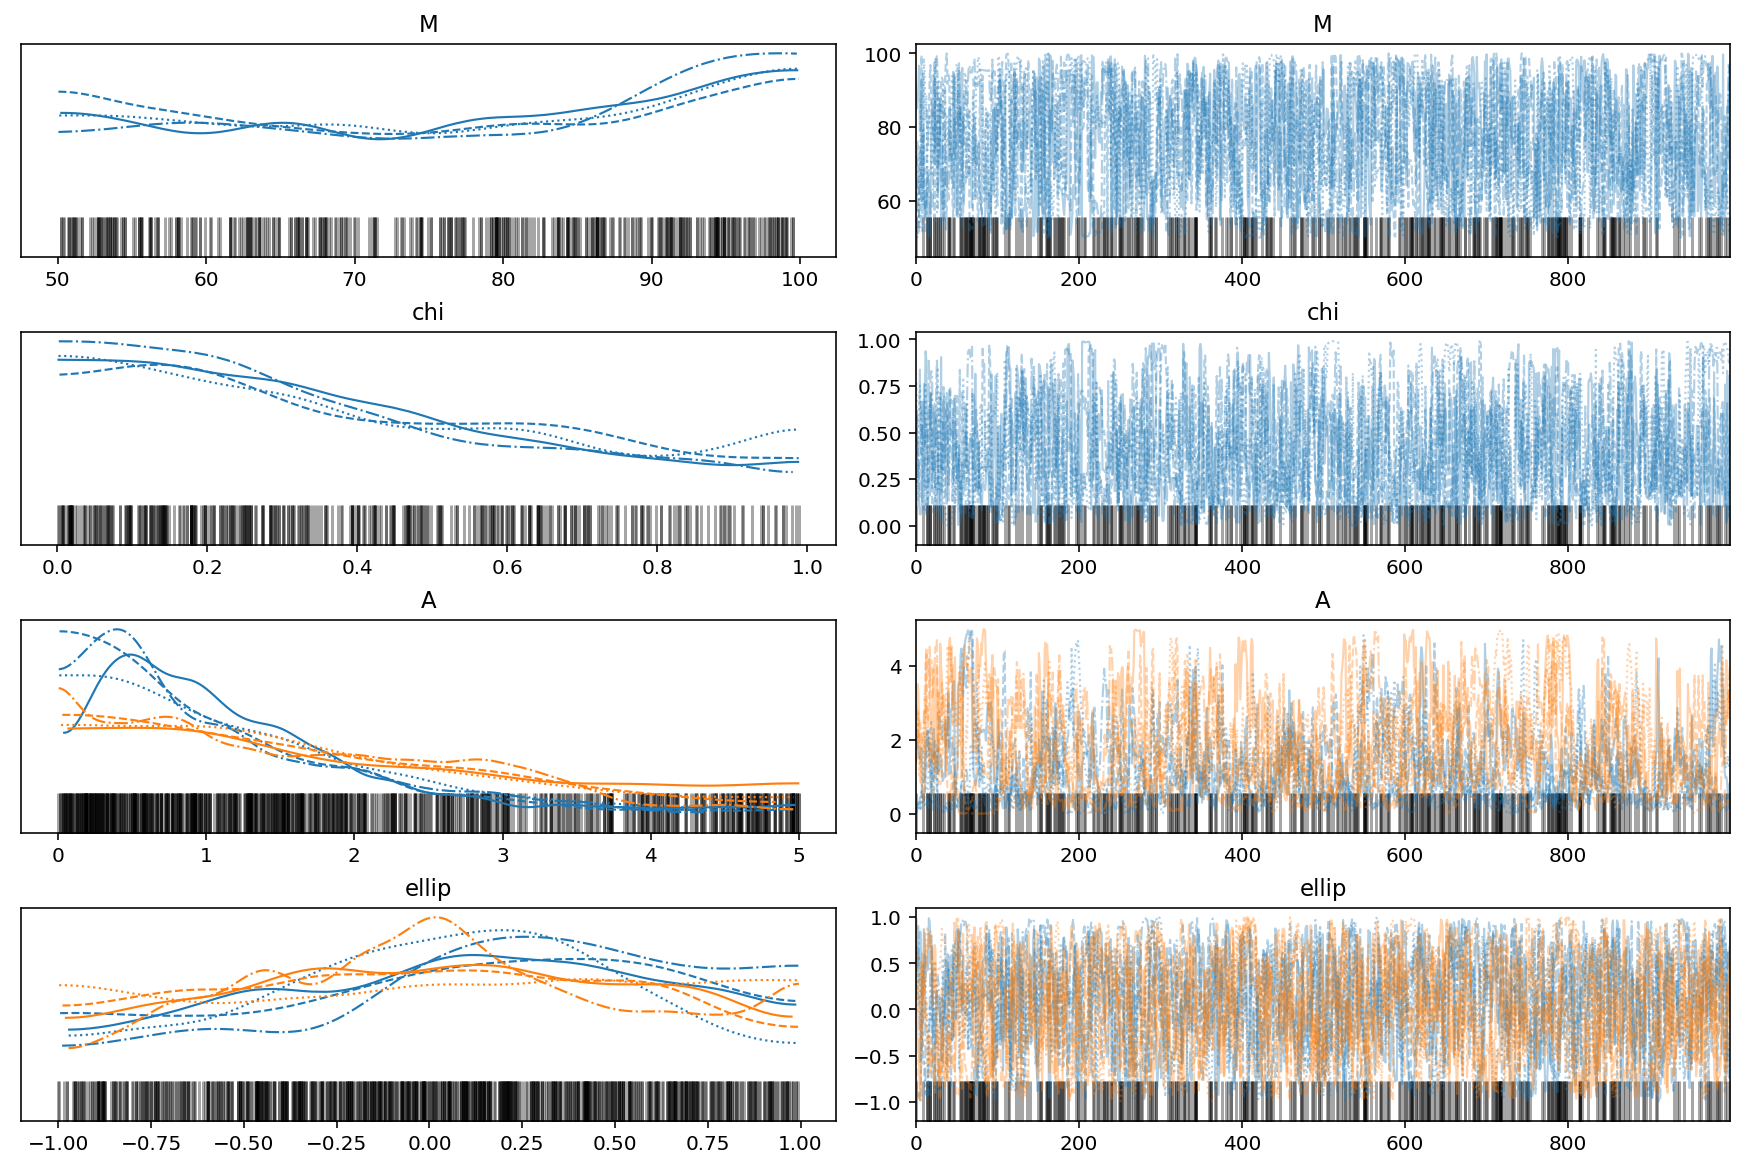

In [68]:
# of course the result is nonsense because there was no signal in the data

import arviz as az
az.plot_trace(f2.result, var_names=['M', 'chi', 'A', 'ellip']);

In [69]:
# we could've also done a prior-only run
f2.run(prior=True)

Running mchi


In [70]:
# the result is saved in prior
f2.prior

Inference data with groups:
	> posterior
	> sample_stats

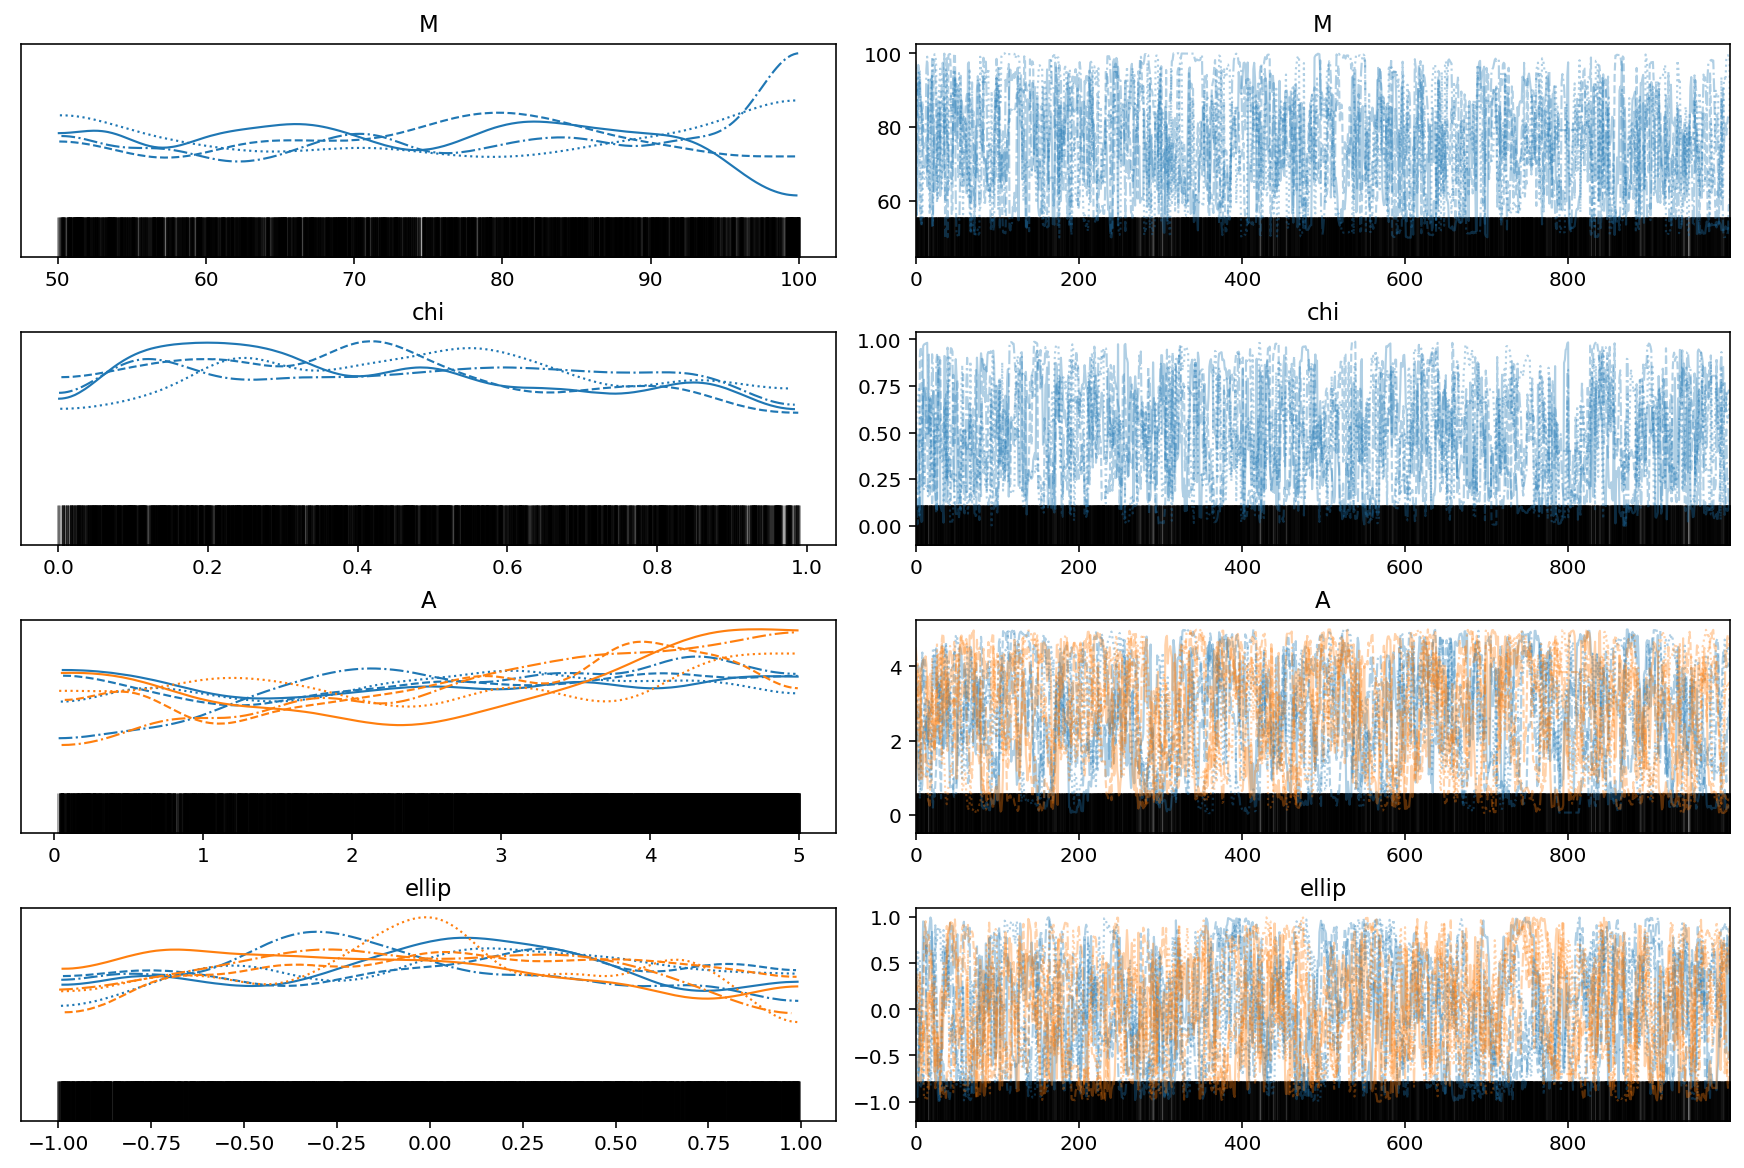

In [75]:
# of course the result is nonsense because there was no signal in the data

import arviz as az
az.plot_trace(f2.prior, var_names=['M', 'chi', 'A', 'ellip']);

In [76]:
# we can check what input was passed to stan by calling
# (could've also done this before running / compiling)

# f2.model_input

#### Frequency-damping fits

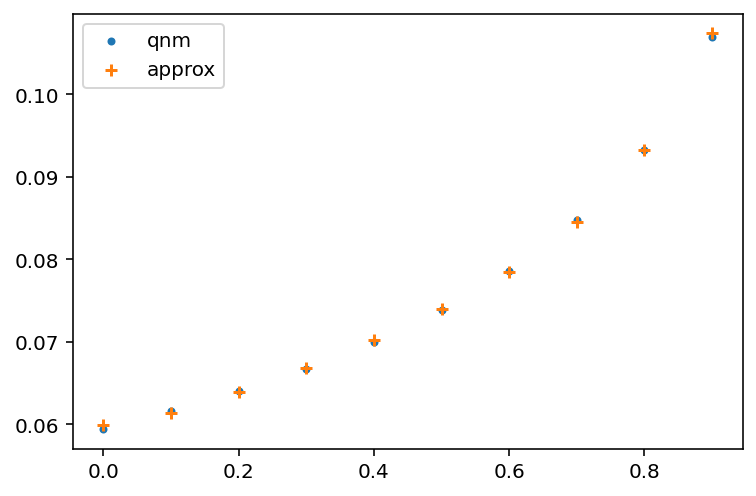

In [78]:
# we can check the approximations used in the Kerr fit
# let's look at the fundamental

mode = gwtones.qnms.KerrMode(f2.modes[0])

chis = linspace(0, 1, 10, endpoint=False)
scatter(chis, mode.ftau(chis)[0], marker='.', label='qnm')
scatter(chis, mode.ftau(chis, approx=True)[0], marker='+', label='approx')
legend();

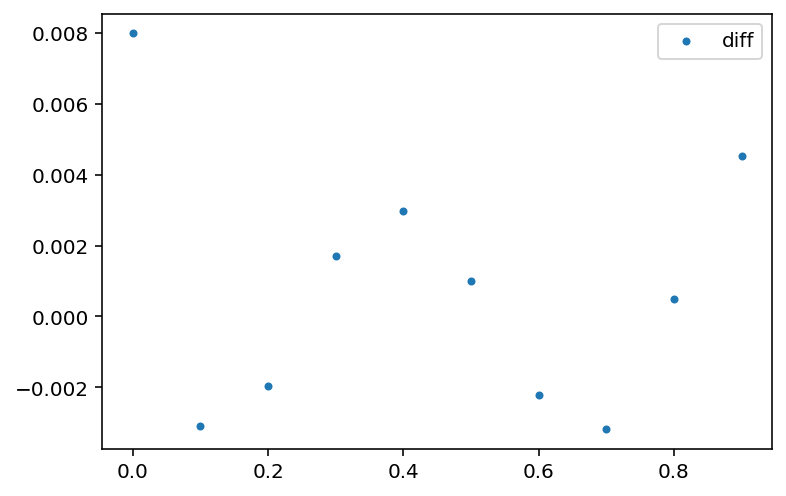

In [80]:
# we can check the approximations used in the Kerr fit
# let's look at the fundamental

mode = gwtones.qnms.KerrMode(f2.modes[0])

chis = linspace(0, 1, 10, endpoint=False)
scatter(chis, (mode.ftau(chis, approx=True)[0] - mode.ftau(chis)[0])/mode.ftau(chis, approx=True)[0], marker='.', label='diff')
legend();